In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def uunifastdiscard(n,ut,discard_limit = 1000):
    sumu = ut
    for i in range(discard_limit):
        utilities = []
        for i in range(n-1):
            nextsumu = sumu*(np.random.random()**(1/(n-1)))
            utilities.append(sumu - nextsumu)
            sumu = nextsumu

        utilities.append(sumu)

        if all(ut <= 1 for ut in utilities):
            return np.array(utilities)
        else:
            sumu = ut

    return False
            

In [3]:
def periods_generation(n,min_period,max_period):
    periods = np.ceil(np.exp(np.random.uniform(low=np.log(min_period), high=np.log(max_period),size=(n))))
    return periods

In [4]:
def execution_times(utilities,periods):
    return np.ceil(utilities * periods)

In [5]:
def task_deadlines(execution_time,period):
    deadline = []
    for i in range(len(execution_time)):
        deadline.append(np.random.uniform(low = execution_time[i] , high = period[i]))

    return np.floor(np.array(deadline))

In [6]:
n = 10
u = 5
def taskset_generation(n,u):
    ut = uunifastdiscard(n,u)
    p = periods_generation(10,1,1000)
    e = execution_times(ut,p)
    d = task_deadlines(e,p)
    taskset = [[p[i],e[i],d[i]] for i in range(len(p))]

taskset_generation(10,5)


## Schedulability tests

In [7]:
def deadline_analysis(ptaskset,m):    #taskset = {period,execution time,deadline}
    num_tasks = len(ptaskset)
    for i in range(num_tasks):
        total_workload = 0
        ei,di = ptaskset[i][1],ptaskset[i][2]
        l = di
        for j in range(i):
            pj,ej,dj = ptaskset[j][0],ptaskset[j][1],ptaskset[j][2]
            max_jobs = np.floor(( l + dj - ej )/pj)
            workload_j = max_jobs*ej + min(ej,l + dj - ej - max_jobs*pj)
            workload_j = min(workload_j,di - ei + 1)
            total_workload += workload_j

        thresh = ei + np.floor(total_workload/m)
        if di < thresh:
            return 0
    return 1

In [8]:
def responsetimeanalysis(ptaskset,m):
    num_tasks = len(ptaskset)
    for i in range(num_tasks):
        ei,di = ptaskset[i][1],ptaskset[i][2]
        l = di
        res = ei
        new_res = ei + 10
        if i == 1:
            if res <= di:
                continue
            else:
                return 0

        while new_res - res > 0.7 and new_res <= di :

            total_workload = 0
            for j in range(i):
                pj,ej = ptaskset[j][0],ptaskset[j][1]
                max_jobs = np.floor(( l + res - ej )/pj)
                workload_j = max_jobs*ej + min(ej,l + res - ej - max_jobs*pj)
                workload_j = min(workload_j,res - ei + 1)
                total_workload += workload_j

            new_res = ei + np.floor(total_workload/m)

        if new_res - res <= 0.7 and new_res <= di :
            continue
        else:
            return 0

    return 1

## Scheduling algorithms

In [9]:
def DMPO(taskset):
    taskset.sort(key = lambda x:x[-1])

In [10]:
def D_CMPO(taskset):
    taskset.sort(key = lambda x:x[-1] - x[-2])

In [11]:
def DkC(taskset,m):
    k = ((m - 1) + np.sqrt(5*m**2 - 6*m + 1))/(2*m)
    taskset.sort(key = lambda x:x[-1] - k*x[-2])    

In [12]:
def OPA(taskset,m):
    ## total concepts and final code
    print("do")

# start

In [13]:
class Task():
    def __init__(self, period, execution_time, deadline ):
        self.period = period
        self.execution_time = execution_time
        self.deadline = deadline
        self.priority = None

    def __repr__(self) -> str:
        return "Task: " +  str(self.period) +" " + str(self.execution_time) + " " + str(self.deadline) + " " + str(self.priority)

class TaskSet():

    def __init__(self, n, ut, min_period, max_period):
        self.n = n
        self.ut = ut
        self.min_period = min_period
        self.max_period = max_period
        self.tasks = None

    def generate(self):
        self.utilities = self.uunifastdiscard()
        if self.utilities is None:
            print("Failed to generate taskset with given parameters")
            return False

        self.periods = self.periods_generation()
        self.execution_time = self.execution_times()
        self.deadline = self.task_deadlines()

        self.tasks = []
        for i in range(self.n):
            self.tasks.append(Task(self.periods[i],self.execution_time[i],self.deadline[i]))
        return True
        

    def uunifastdiscard(self,discard_limit = 1000):
        sumu = self.ut
        for j in range(discard_limit):
            utilities = []
            for i in range(self.n-1):
                nextsumu = sumu*(np.random.random()**(1/(self.n-i+1)))
                utilities.append(sumu - nextsumu)
                sumu = nextsumu

            utilities.append(sumu)

            if all(ut <= 1 for ut in utilities):
                return np.array(utilities)
            else:
                sumu = self.ut

        return None
    
    def periods_generation(self):
        periods = np.ceil(np.exp(np.random.uniform(low=np.log(self.min_period), high=np.log(self.max_period),size=(self.n))))
        return periods
    
    def execution_times(self):
        return np.ceil(self.utilities * self.periods)
    
    def task_deadlines(self):
        deadline = []
        for i in range(len(self.execution_time)):
            deadline.append(np.random.uniform(low = self.execution_time[i] , high = self.periods[i]))

        return np.floor(np.array(deadline))

In [14]:
def DMPO(set):
    set.sort(key = lambda x:x.deadline)

In [15]:
def D_CMPO(taskset):
    taskset.sort(key = lambda x:x.deadline - x.execution_time)

In [16]:
def DkC(taskset,m):
    k = ((m - 1) + np.sqrt(5*m**2 - 6*m + 1))/(2*m)
    taskset.sort(key = lambda x:x.deadline - k*x.execution_time)

In [17]:
def OPA(taskset, cores, S_test):
    N = len(taskset)

    assigned_tasks = []

    taskset_copy = taskset.copy()

    priority_assigned = [False] * N

    for i in range(N-1,-1,-1):

        for j,task in enumerate(taskset_copy):

            if not priority_assigned[j]:
                if(S_test(assigned_tasks + [task],cores)):
                    task.priority = i
                    priority_assigned[j] = True
                    assigned_tasks.append(task)
                    break
        else:
            return False
            return taskset_copy,(i)/N*100
    return True
    return taskset_copy,100

In [18]:
def deadline_analysis_OPA(ptaskset,m):    #taskset = {period,execution time,deadline}
    Ck = ptaskset[-1].execution_time
    Dk = ptaskset[-1].deadline
    l = Dk
    total_workload = 0

    for task in ptaskset[:-1]:
        Ti,Ci,Di = task.period,task.execution_time,task.deadline
        max_jobs = np.floor(( l + Di - Ci )/Ti)
        workload_task = max_jobs*Ci + min(Ci,l + Di - Ci - max_jobs*Ti)
        workload_task = min(workload_task,Dk - Ck + 1)
        total_workload += workload_task

        thresh = Ck + np.floor(total_workload/m)
        if Dk < thresh:
            return 0
    return 1

In [19]:
def deadline_analysis(ptaskset,m):    #taskset = {period,execution time,deadline}
    num_tasks = len(ptaskset)
    cleared = 0
    for k in range(num_tasks):
        
        total_workload = 0
        Ck,Dk = ptaskset[k].execution_time,ptaskset[k].deadline
        l = Dk
        for i in range(k):
            Ti,Ci,Di = ptaskset[i].period,ptaskset[i].execution_time,ptaskset[i].deadline
            max_jobs = np.floor(( l + Di - Ci )/Ti)
            workload_j = max_jobs*Ci + min(Ci,l + Di - Ci - max_jobs*Ti)
            workload_j = min(workload_j,Dk - Ck + 1)
            total_workload += workload_j

        thresh = Ck + np.floor(total_workload/m)
        if Dk >= thresh:
            cleared += 1

    return (cleared/num_tasks)*100

In [93]:
def responsetimeanalysis(ptaskset,m):
    num_tasks = len(ptaskset)
    cleared = 0
    for k in range(num_tasks):
        Ck,Dk = ptaskset[k].execution_time,ptaskset[k].deadline
        l = Dk
        res = Ck
        new_res = Ck
        if k == 0:
            if res <= Dk:
                cleared += 1
                continue
               
        else:       
            while new_res <= Dk:
                res = new_res
                total_workload = 0
                for i in range(k):
                    Ti,Ci = ptaskset[i].period,ptaskset[i].execution_time
                    max_jobs = np.floor(( l + res - Ci )/Ti)
                    workload_j = max_jobs*Ci + min(Ci,l + res - Ci - max_jobs*Ti)
                    workload_j = min(workload_j,res - Ck + 1)
                    total_workload += workload_j

                new_res = Ck + np.floor(total_workload/m)
                if new_res - res <= 0.0001:
                    break

        if new_res <= Dk :
            cleared += 1

    return (cleared/num_tasks)*100

In [21]:
#cores = 2
#taskset = TaskSet(cores*5,0.6,10,100)
#taskset.generate()
#DMPO(taskset.tasks)
#v = deadline_analysis(taskset.tasks,cores)
#print(v)

In [22]:
#cores = 2
#ut = np.linspace(0.1,cores,20)
#sch = []
#for i in ut:
#    avg = 0
#    for j in range(1000):
#        #print(j)
#        taskset = TaskSet(cores*5,i,10,100)
#        taskset.generate()
#        DMPO(taskset.tasks)
#        v = deadline_analysis(taskset.tasks,cores)
#        avg += v
#    sch.append(avg/1000)
#plt.plot(ut,sch,label = 'DMPO') 
#sch = []
#for i in ut:
#    avg = 0
#    for j in range(1000):
#        #print(j)
#        taskset = TaskSet(cores*5,i,10,100)
#        taskset.generate()
#        D_CMPO(taskset.tasks)
#        v = deadline_analysis(taskset.tasks,cores)
#        avg += v
#    sch.append(avg/1000)
#
#
#plt.plot(ut,sch,label = 'D_CMPO') 
#
#sch = []
#for i in ut:
#    avg = 0
#    for j in range(1000):
#        taskset = TaskSet(cores*5,i,10,100)
#        taskset.generate()
#        DkC(taskset.tasks,cores)
#        v = deadline_analysis(taskset.tasks,cores)
#        avg += v
#    sch.append(avg/1000)
#
#plt.plot(ut,sch,label = 'DkC') 
#
#plt.legend()
#plt.show()

In [23]:
#cores = 2
#ut = np.linspace(0.1,cores,25)
#
#sch = []
#
#for i in ut:
#    #avg = 0
#    #for j in range(1000):
#        #print(j)
#        taskset = TaskSet(cores*5,i,10,100)
#        taskset.generate()
#        DMPO(taskset.tasks)
#        v = deadline_analysis(taskset.tasks,cores)
#        #avg += v
#        sch.append(v)
#plt.plot(ut,sch,label = 'DMPO')

In [24]:
def generate_tasksets(n_tasksets, n_tasks, max_utility, min_period, max_period):
    set_tasksets = []
    for i in range(n_tasksets):
        set = TaskSet(n_tasks,max_utility,min_period,max_period)
        set.generate()
        set_tasksets.append(set)
    
    return set_tasksets

In [33]:
set_tasksets = []
n_tasksets = 1000

cores = 2
n_tasks = 5*cores
min_period = 10
max_period = 1000
us = np.arange(0.1,cores,0.1)


percentage_schedulable_OPA = []
percentage_schedulable_DMPO = []
percentage_schedulable_D_CMPO = []
percentage_schedulable_DkC = []
for u in us:
    percentage_OPA = 0
    percentage_DCMPO = 0
    percentage_DMPO = 0
    percentage_DkC = 0
    set_tasksets = generate_tasksets(n_tasksets, n_tasks, u, min_period, max_period)
    for i in range(n_tasksets):
        set = set_tasksets[i]
        # ordered_tasks,percentage = OPA(set.tasks, cores, deadline_analysis_OPA)
        # percentage_OPA += percentage
        percentage_OPA += int(OPA(set.tasks, cores, deadline_analysis_OPA))
        

        set = set_tasksets[i]
        DMPO(set.tasks)
        # percentage_DMPO += deadline_analysis(set.tasks,cores)
        percentage_DMPO += int(deadline_analysis(set.tasks,cores))

        set = set_tasksets[i]
        D_CMPO(set.tasks)
        # percentage_DCMPO += deadline_analysis(set.tasks,cores)
        percentage_DCMPO += int(deadline_analysis(set.tasks,cores))

        set = set_tasksets[i]
        DkC(set.tasks,cores)
        # percentage_DkC += deadline_analysis(set.tasks,cores)
        percentage_DkC += int(deadline_analysis(set.tasks,cores))

    percentage_schedulable_OPA.append(percentage_OPA/n_tasksets)
    percentage_schedulable_DMPO.append(percentage_DMPO/n_tasksets)
    percentage_schedulable_D_CMPO.append(percentage_DCMPO/n_tasksets)
    percentage_schedulable_DkC.append(percentage_DkC/n_tasksets)

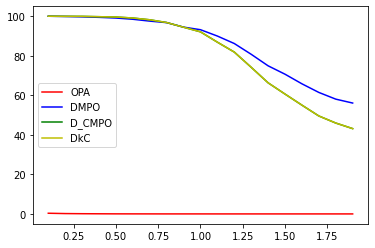

In [34]:
plt.figure()
plt.plot(us,percentage_schedulable_OPA,color='r',label='OPA')
plt.plot(us,percentage_schedulable_DMPO,color='b',label='DMPO')
plt.plot(us,percentage_schedulable_D_CMPO,color='g',label='D_CMPO')
plt.plot(us,percentage_schedulable_DkC,color='y',label='DkC',linestyle='-')
plt.legend()

In [96]:
set_tasksets = []
n_tasksets = 100

cores = 2
n_tasks = 5*cores
min_period = 10
max_period = 1000
us = np.arange(0.1,2,0.1)


percentage_schedulable_OPA = []
percentage_schedulable_DMPO = []
percentage_schedulable_D_CMPO = []
percentage_schedulable_DkC = []
for u in us:
    percentage_OPA = 0
    percentage_DCMPO = 0
    percentage_DMPO = 0
    percentage_DkC = 0
    set_tasksets = generate_tasksets(n_tasksets, n_tasks, u, min_period, max_period)
    for i in range(n_tasksets):
        

        set = set_tasksets[i]
        DMPO(set.tasks)
        percentage_DMPO += responsetimeanalysis(set.tasks,cores)

        set = set_tasksets[i]
        D_CMPO(set.tasks)
        percentage_DCMPO += responsetimeanalysis(set.tasks,cores)

        set = set_tasksets[i]
        DkC(set.tasks,cores)
        percentage_DkC += responsetimeanalysis(set.tasks,cores)

    # percentage_schedulable_OPA.append(percentage_OPA/n_tasksets)
    percentage_schedulable_DMPO.append(percentage_DMPO/n_tasksets)
    percentage_schedulable_D_CMPO.append(percentage_DCMPO/n_tasksets)
    percentage_schedulable_DkC.append(percentage_DkC/n_tasksets)
        

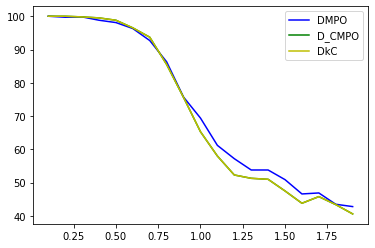

In [97]:
plt.figure()
plt.plot(us,percentage_schedulable_DMPO,color='b',label='DMPO')
plt.plot(us,percentage_schedulable_D_CMPO,color='g',label='D_CMPO')
plt.plot(us,percentage_schedulable_DkC,color='y',label='DkC',linestyle='-')
plt.legend()

In [58]:
cores = 2
set = TaskSet(cores*5,0.2,10,100)

set.generate()
print(set.tasks)

[Task: 14.0 1.0 9.0 None, Task: 12.0 1.0 8.0 None, Task: 15.0 1.0 12.0 None, Task: 64.0 2.0 32.0 None, Task: 39.0 1.0 9.0 None, Task: 34.0 1.0 23.0 None, Task: 16.0 1.0 9.0 None, Task: 83.0 1.0 44.0 None, Task: 15.0 1.0 1.0 None, Task: 34.0 2.0 5.0 None]


In [69]:
x = responsetimeanalysis(set.tasks,cores)
print(x)

90.0
